In [1]:
import glob
import itertools 
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pybedtools as pb
import pandas as pd
from scipy import stats

import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import subprocess
import time


sys.path.append("/dors/capra_lab/users/fongsl/tools/py_/")
import count_lines as cl
import fet
import plot_params as pp

sys.path.append("/dors/capra_lab/users/fongsl/tools/genome/")
import config_readwrite as crw
import chr_functions
import split_filename

pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
BRANCH = "br-hg38.mod-hg38"   
#BRANCH = "br-hg38.mod-full"  

In [3]:
NAME = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config"
config, configile_nameF = crw.read_config(NAME)

REGIONS = config["CIS_TRANS"]["regions"] # intersect w/extended summits
REGIONS_ANNOT = config["CIS_TRANS"]["regions_annotations"] # intersect w/extended summits
REGIONSxBINS = config["CIS_TRANS"]["regions_x_bins"]

RE = config["PHYLOP"]["results"]

BINS = config["BINS"]["bins"]
CONACC_BINS = config["PHYLOP"]["conacc_tiles"]
CONACC_REGIONS_PATH = config["PHYLOP"]["regions_path"]

SELF_BINS = config["SELF"]["data"]

SHUF = config["SHUFFLES"]["shuf-all"]
SHUFxBINS = config["SHUFFLES"]["shuf_x_bins"] # write

PHYLOP_REGIONS=config["PHYLOP"][f"regions_no_self_{BRANCH}"]  # write

# intersect regions, shuffles with bins
regions have to be intersected w/ bins in order to find bin with lowest (most negative) phylop value

In [4]:
def intersect_regions_x_bins(bins, regions, outfile):

    if os.path.exists(outfile) is False:
        b, r = pb.BedTool(bins), pb.BedTool(regions)
        r.intersect(b, wao=True, output=outfile)
    else:
        print("did this intersection already:", outfile)
    

In [5]:
pairs = [
        (REGIONS, REGIONSxBINS), 
        (SHUF, SHUFxBINS)
        ]

for i, j in pairs:
    intersect_regions_x_bins(BINS, i, j)

did this intersection already: /data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/regions/all_uniq_diffAct_regions2_x_bins.bed
did this intersection already: /data/hodges_lab/ATAC-STARR_B-cells/data/hansen-fong/bkgd_sharedAcc_regions/shuffles/shuf-all_uniq_diffAct_regions2-all_x_bins.bed


# intersect w conacc

In [6]:
def merge_bins_x_conacc(region_x_bin, conacc):

    """
    return intersection of region_x_bin and phylop values
    
    input 
        bin_file - file with region coordinates x bin coordinates and annotations
        conacc - file with 50bp window phyloP measurements

    method
        1. open conacc file as pandas dataframe
        2. open region_x_bin file as pandas dataframe 
        3. rename columns in region_x_bin dataframe
        4. keep only bins where 50bp of the bin overlaps the region 
            (removes the edge effects where a region might not totally encompass a bin)
            
        5. merge region_x_bin dataframe with conacc dataframe on the bin annotation
        
        6. if shuffle, add shuffle_id, else keep region_id in shuf_id column
        
    output
        dataframe w/ region, bin, and conacc scores for each bin
    """
    
    #1
    conacc_df = pd.read_csv(conacc, sep = '\t')
    
    #2
    bin_df = pd.read_csv(region_x_bin, sep = '\t', header = None)
    
    #3 rename columns
    bin_cols = [
                "#chr", "start", "end", "region_id", 
                "#chr_bin", "start_bin", "end_bin", "bin", 
                "overlap"
               ]
    
    bin_df.columns = bin_cols
    
    #4 keep only bins that fully overlap the region. 
    bin_df = bin_df.loc[bin_df['overlap']==50]
    
    #5
    bin_df = pd.merge(bin_df, conacc_df).drop_duplicates()
    
    #6 
    if "shuf" in region_x_bin:
        bin_df["shuf_id"] = bin_df["#chr"] + ":"+ bin_df["start"].map(str)+ "-" + bin_df["end"].map(str)
    else:
        bin_df["shuf_id"] = bin_df["region_id"]
    
    return bin_df


In [7]:
REGxBINxCON= merge_bins_x_conacc(REGIONSxBINS, CONACC_BINS)
SHUFxBINxCON= merge_bins_x_conacc(SHUFxBINS, CONACC_BINS)

# REMOVE SELF 

In [8]:
def remove_self(self_bins, regxbinxcon):
    
    """
    return dataframe w/ self overlapping bins removed
    
    input - 
        self bins annotations (file) - TRUE = any bin where 50% of the bases overlap a self element
        regxbinxcon - (dataframe) regions mapped to bins mapped to phylop scores. 
        
    output 
        regxbinxcon with self elements removed
    
    method
        1. load self dataframe
        2. keep only the bin and self columns
        3. merge with regxbinxcon dataframe on bin annotation
        4. remove all the bins that overlap self

        
    """
    print(regxbinxcon.shape[0])
    #1
    self = pd.read_csv(self_bins, sep='\t')
    #2
    self = self[["bin", "self"]].drop_duplicates()
    #3
    df = pd.merge(regxbinxcon, self, on = "bin")
    #4
    noself = df.loc[df["self"]==False]
    
    print(noself.shape[0])
    
    return noself

In [9]:
REGxBINxCON = remove_self(SELF_BINS, REGxBINxCON)
SHUFxBINxCON = remove_self(SELF_BINS, SHUFxBINxCON)

246620
170659
1426134
1004641


# get min phylop scoring bin per region 

In [10]:
def get_min_phylop(df, branch, id_col):
    
    """
    return min phylop bin (50bp) in region 
    
    input 
        df - dataframe w/ region id and phyloP branch measurements
        branch (str) - column name for branch measured w phyloP
        id col - can be "shuf_id" or "region_id", 
            as region_id in shuffled dataframe corresponds to the original region the shuffle was made for.

    method
        1. drop duplicates
        2. groupby region_id, get min phyloP value for branch test
        3. rename the branch column as "phylop"
        4. add column for the phylop test
        
    output
        dataframe w/ two columns: region_id and min phyloP value
    """
    
    #1
    df = df[[id_col, branch, "region_id"]].drop_duplicates()
    
    #2
    min_phylop = df.groupby([id_col, "region_id"])[branch].min().reset_index()

    #3
    min_phylop = min_phylop.rename(columns = {branch:"phylop"})
    
    #4
    min_phylop["phylop_test"]=branch
    
    return min_phylop

In [11]:
REGION_ID = "shuf_id"

reg_min, shuf_min = get_min_phylop(REGxBINxCON, BRANCH, REGION_ID), get_min_phylop(SHUFxBINxCON, BRANCH, REGION_ID)

In [12]:
print(reg_min.shape, shuf_min.shape)

reg_min.describe(), shuf_min.describe()

(12292, 4) (119248, 4)


(             phylop
 count  12292.000000
 mean      -0.229947
 std        0.573031
 min       -7.579000
 25%       -0.504000
 50%       -0.170000
 75%        0.076000
 max        2.029000,
               phylop
 count  119248.000000
 mean       -0.061510
 std         0.618278
 min        -8.412000
 25%        -0.370000
 50%        -0.052000
 75%         0.240000
 max         3.312000)

# save the min phylop bin score for each region that does not overlap self. 

In [13]:
if os.path.exists(PHYLOP_REGIONS) is False:
    reg_min[["region_id", "phylop"]].drop_duplicates().to_csv(PHYLOP_REGIONS, sep = '\t', index=False)

# plot distribution of min phylop scores 

In [14]:
stats.mannwhitneyu(reg_min["phylop"], shuf_min["phylop"])

MannwhitneyuResult(statistic=612125959.5, pvalue=9.985342830933816e-200)

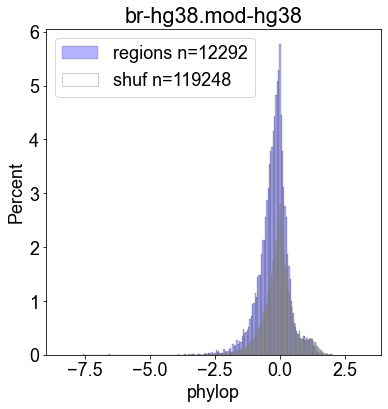

In [15]:
x="phylop"

fig,ax =plt.subplots(figsize=(6,6))
data = reg_min

sns.histplot(x=x, data=data, label = f"regions n={data.shape[0]}",  color = "blue", alpha = 0.3,stat="percent", common_norm=False)

data = shuf_min

sns.histplot(x=x, data=data, label = f"shuf n={data.shape[0]}", 
             color = "grey", alpha = 0.8, fill=False, stat="percent", common_norm=False)

plt.legend(loc="upper left")
plt.title(BRANCH)
out = os.path.join(RE, f"{BRANCH}-regions_x_shuf_min_phylop_dist.pdf")
plt.savefig(out, bbox_inches="tight")
                   

# open regions annotation file 

In [16]:
regions = pd.read_csv(REGIONS_ANNOT, sep = '\t')
regions.head()

,#chr,start,end,region_id,conserved_active.regions,cis,trans,trans_only,cis_only,cis+trans,...,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans,peak_id
0,chr1,959034,959154,chr1:959034-959154,0.0,1.0,1.0,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,chr1:958624-959633
1,chr1,1002089,1002179,chr1:1002089-1002179,0.0,1.0,1.0,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,chr1:1001489-1002748
2,chr1,1064140,1064260,chr1:1064140-1064260,0.0,1.0,0.0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chr1:1063549-1064889
3,chr1,1214948,1215208,chr1:1214948-1215208,0.0,1.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,chr1:1214708-1216904
4,chr1,1215328,1215508,chr1:1215328-1215508,0.0,1.0,0.0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,chr1:1214708-1216904


In [17]:
# cols to test for enrichment v. shuffle

active_categories = [
            'conserved_active.regions',

            'cis_only',
            'trans_only',
            'cis+trans',

            'HH-active_MM-inactive_cis-only',
            'HH-active_MM-inactive_trans-only',
            'HH-active_MM-inactive_cis+trans',

            'MM-active_HH-inactive_cis-only',
            'MM-active_HH-inactive_trans-only',
            'MM-active_HH-inactive_cis+trans'
            ]

# nominal phylop cutoffs

cutoffs = [-2, -1.3, -1, -0.5, 0]

# combine active_categories w/ cutoffs

categories_x_cutoffs = itertools.product(active_categories, cutoffs)

In [18]:
def get_active_category_region_ids(region_annot, active_category):
    """
    return set of region_ids overlapping the activity category
    
    input
        region_annot (pandas dataframe) - dataframe with region_id and activity category as column
        activity_category (str) - name of column w/ activity annotation
    
    output
        set list of region_ids that overlap that activity category
    
    """
    
    ids = list(set(region_annot.loc[region_annot[active_category]==1, "region_id"]))

    return ids

In [19]:
cis_only = get_active_category_region_ids(regions, "cis_only")

In [20]:
cmin, shuf_cmin = reg_min.loc[reg_min["region_id"].isin(cis_only)], shuf_min.loc[shuf_min["region_id"].isin(cis_only)], 

In [21]:
cmin.head()

,shuf_id,region_id,phylop,phylop_test
5,chr10:100267780-100267910,chr10:100267780-100267910,-0.695,br-hg38.mod-hg38
19,chr10:101587898-101588108,chr10:101587898-101588108,-0.461,br-hg38.mod-hg38
25,chr10:101818413-101818523,chr10:101818413-101818523,0.302,br-hg38.mod-hg38
32,chr10:102151839-102151969,chr10:102151839-102151969,-0.191,br-hg38.mod-hg38
40,chr10:102646298-102646528,chr10:102646298-102646528,-0.432,br-hg38.mod-hg38


# NLRP1 accelerated region 

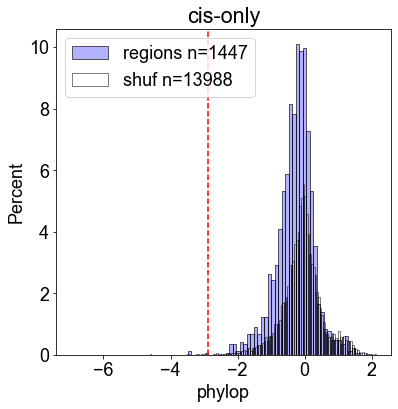

In [22]:
x="phylop"

fig,ax =plt.subplots(figsize=(6,6))
data = cmin

sns.histplot(x=x, data=data, label = f"regions n={data.shape[0]}",  color = "blue", alpha = 0.3,stat="percent", common_norm=False)

data = shuf_cmin

sns.histplot(x=x, data=data, label = f"shuf n={data.shape[0]}", 
             color = "k", alpha = 1, fill=False, stat="percent", common_norm=False)


plt.axvline(-2.89, ls = "--", color ="r")
plt.legend(loc="upper left")
#plt.title(BRANCH)
plt.title("cis-only")
out = os.path.join(RE, f"{BRANCH}-regions_x_shuf_min_phylop_dist_cis_only.pdf")
plt.savefig(out, bbox_inches="tight")
                   

In [23]:
reg_min["phylop_rank"] = reg_min["phylop"].rank()
cmin["phylop_rank"] = cmin["phylop"].rank()
cmin["phylop_rank_pct"] = cmin["phylop"].rank(pct=True)
cmin["phylop_rank_pct"] = 1-cmin["phylop_rank_pct"]

/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [24]:
cmin.shape

(1447, 6)

In [25]:
cmin.sort_values(by ="phylop").head(25)

,shuf_id,region_id,phylop,phylop_test,phylop_rank,phylop_rank_pct
12015,chr9:136849380-136849640,chr9:136849380-136849640,-3.492,br-hg38.mod-hg38,1.0,0.999309
569,chr10:97412859-97413209,chr10:97412859-97413209,-3.476,br-hg38.mod-hg38,2.0,0.998618
5922,chr1:70410835-70411095,chr1:70410835-70411095,-2.901,br-hg38.mod-hg38,3.0,0.997927
10301,chr6:2858593-2858693,chr6:2858593-2858693,-2.300,br-hg38.mod-hg38,4.0,0.997236
4887,chr1:165631980-165632190,chr1:165631980-165632190,-2.241,br-hg38.mod-hg38,5.0,0.996545
930,chr11:47268738-47269138,chr11:47268738-47269138,-2.187,br-hg38.mod-hg38,6.0,0.995853
9704,chr5:181191716-181191876,chr5:181191716-181191876,-2.164,br-hg38.mod-hg38,7.0,0.995162
3062,chr14:99481379-99481669,chr14:99481379-99481669,-2.159,br-hg38.mod-hg38,8.0,0.994471
10823,chr7:138000178-138000448,chr7:138000178-138000448,-2.139,br-hg38.mod-hg38,9.0,0.993780
1301,chr11:77820601-77820931,chr11:77820601-77820931,-2.135,br-hg38.mod-hg38,10.0,0.993089


In [26]:
reg_min.loc[reg_min["region_id"].str.contains("chr17")].sort_values(by = "phylop")

,shuf_id,region_id,phylop,phylop_test,phylop_rank
3927,chr17:30477241-30477721,chr17:30477241-30477721,-3.914,br-hg38.mod-hg38,3.0
3911,chr17:29294315-29294505,chr17:29294315-29294505,-3.285,br-hg38.mod-hg38,10.0
4135,chr17:67366380-67366680,chr17:67366380-67366680,-2.740,br-hg38.mod-hg38,22.0
4174,chr17:7252371-7252611,chr17:7252371-7252611,-2.415,br-hg38.mod-hg38,54.0
3884,chr17:28335288-28335818,chr17:28335288-28335818,-2.304,br-hg38.mod-hg38,69.0
...,...,...,...,...,...
4324,chr17:80545328-80545428,chr17:80545328-80545428,1.191,br-hg38.mod-hg38,12152.0
4255,chr17:7632621-7632711,chr17:7632621-7632711,1.205,br-hg38.mod-hg38,12162.5
4109,chr17:58339759-58339859,chr17:58339759-58339859,1.226,br-hg38.mod-hg38,12174.5
4074,chr17:57603842-57603932,chr17:57603842-57603932,1.265,br-hg38.mod-hg38,12200.0


# test conserved activity column for enrichment 

In [27]:
def compute_OR_v_shuf(region_annot, reg_min_df, shuf_min_df, active_category, cutoff):
    """
    return enrichment of activity col for min phylop versus 10x matched background
    
    input
        region_annot (dataframe) - differential activity annotations for each region
        reg_min_df (dataframe) - regions dataframe with shuf_id (copy of region_id), region_id, and min_phylop columns
        shuf_min_df (dataframe) - matched shuffles dataframe with shuf_id, region_id, and min_phylop columns
        
        active_category (str) - activity column to measure enrichment of phylop scores 
        cutoff (int) - nominal phylop cutoff
    
    output
        dataframe with fisher's exact test for enrichment of regions w/ phylop scores lower than cutoff 
            versus length-matched shuffles in the shared accessible, inactive background. 
        
    method
        1. get region_ids to test w/ function get_active_category_region_ids
        2. get subset of dataframes overlapping these region_ids
        3. count number of elements with value more extreme than phylop cutoff, less than or equal to cutoff
            for regions, for matched shuffles
        4. name comparison
        5. quantify FET enrichment
        6. add columns to identify test
        7. return FET dataframe
    """
   
    #1
    active_ids = get_active_category_region_ids(region_annot, active_category)
    
    #2
    act_regions = reg_min_df.loc[(reg_min_df["region_id"].isin(active_ids))]
    act_shufs = shuf_min_df.loc[(shuf_min_df["region_id"].isin(active_ids))]
    
    #3
    a,b = act_regions.loc[act_regions["phylop"]<cutoff].shape[0], act_regions.loc[act_regions["phylop"]>=cutoff].shape[0]
    c,d = act_shufs.loc[act_shufs["phylop"]<cutoff].shape[0], act_shufs.loc[act_shufs["phylop"]>=cutoff].shape[0]
    
    #4
    comparison = f"{active_category}-region_v_shuf_phylop{cutoff}"
    
    #5
    OR = fet.get_2x2(a,b,c,d, comparison)
    
    #6
    OR["bkgd"] = "matched_shufffle"
    
    OR["phylop_cutoff"] = cutoff
    
    OR["activity"] = active_category
    
    OR["-log10p"] = np.log10(OR["P"])*-1
    
    OR["frac"]=OR["a"]/(OR["a"]+OR["b"])
    OR["frac"] = OR["frac"].round(2)
    
    OR["astrisks"] = None
    OR.loc[OR["P"]<0.05, "astrisks"] = "*"
    
    OR = OR.replace(-np.inf, -1)
    
    #7
    return OR

In [28]:
results_ = {}

for active_category, cutoff in categories_x_cutoffs:
    
    key = f"{active_category}{cutoff}"
    or_ = compute_OR_v_shuf(regions, reg_min, shuf_min, active_category, cutoff)
    results_[key]=or_

[[26, 1634], [131, 16249]]
conserved_active.regions-region_v_shuf_phylop-2 [[26, 1634], [131, 16249]] 1.9736795388079644 0.0031666705396767142
[[110, 1550], [641, 15739]]
conserved_active.regions-region_v_shuf_phylop-1.3 [[110, 1550], [641, 15739]] 1.742529314075789 8.099249579564785e-07
[[204, 1456], [1222, 15158]]
conserved_active.regions-region_v_shuf_phylop-1 [[204, 1456], [1222, 15158]] 1.7379588496609772 6.476250206483819e-11
[[569, 1091], [3767, 12613]]
conserved_active.regions-region_v_shuf_phylop-0.5 [[569, 1091], [3767, 12613]] 1.7462655698079492 5.044240357456606e-23
[[1291, 369], [10354, 6026]]
conserved_active.regions-region_v_shuf_phylop0 [[1291, 369], [10354, 6026]] 2.0362019208370565 3.1906196278698534e-34
[[16, 1431], [106, 13882]]
cis_only-region_v_shuf_phylop-2 [[16, 1431], [106, 13882]] 1.4642880687736508 0.15912065304134868
[[71, 1376], [467, 13521]]
cis_only-region_v_shuf_phylop-1.3 [[71, 1376], [467, 13521]] 1.493935498730143 0.0032057769103314227
[[140, 1307], [

In [29]:
results = fet.fdr_correction(results_)

In [30]:
#results = pd.concat(results_.values())
active_comps = [
                ("all", [
                'cis_only',    
                'trans_only',
                'cis+trans',
                'conserved_active.regions',
                ]),

                ("HH-active", [
                'HH-active_MM-inactive_cis-only',
                'HH-active_MM-inactive_trans-only',
                'HH-active_MM-inactive_cis+trans'
                ]),

                ("MM-active",[
                'MM-active_HH-inactive_cis-only',
                'MM-active_HH-inactive_trans-only',
                'MM-active_HH-inactive_cis+trans'])
                ]



# plot OR results for regions x shuffles 

In [31]:
def annotate_bar(graph, annot, height):
    for p, a in zip(graph.patches, annot):

        graph.annotate(a, 
                            (p.get_x() + p.get_width() / 2.0, height),
                            #p.get_height()-1), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

In [32]:
def reindex_in_comp_order(data, comp):
    d = data.set_index("activity")
    d = d.loc[comp].reset_index()
    return d

In [33]:
def plot_or(active_comps, plot_results, bkgd, branch):
    
    """
    plot odds ratio
    
    active_comps (list) of tuples - groups of activity categories to compare
    """
    for name, comp in active_comps:

        y="OR_log2"
        x="activity"
        size="frac"
        ci_upper, ci_lower= "ci_upper_log2", "ci_lower_log2"

        fig, ax_ = plt.subplots(ncols = 3, nrows =2, figsize =(22,14))
        row = 0

        if "HH" in name or "MM" in name:
            palette=sns.color_palette()[1:]
        else:
            palette = sns.color_palette()

        for i, cutoff in enumerate(cutoffs):

            if i>2:
                row =1
                col = i-3
            else:
                col = i
            ax = ax_[row][col]

            test = plot_results.loc[(plot_results["activity"].isin(comp))
                              &(plot_results["phylop_cutoff"]==cutoff)]
            data=reindex_in_comp_order(test, comp)


            # get difference between y and upper/lower CI for plotting. 
            l = np.array(data[y]-data[ci_lower])
            u = np.array(data[ci_upper]- data[y])

            yerr = [l, u]

            sns.barplot(
                x=x, y=y, data=data,
                order = comp,
                palette=palette,
                linewidth=2.5, 
                edgecolor=".2",
                **{"yerr":yerr},
                ax=ax

                )
            ax.set(xlabel =branch,
                   ylabel = "log2OR",
                   title=f"{name} v {bkgd}, phylop={cutoff}",
                   ylim =(-1, (data[ci_upper].max()+data[ci_upper].max()*0.5))
                  )
            #if data[ci_lower].min()>-0.2:
             #   ax.set_ylim(-1, (data[ci_upper].max()+data[ci_upper].max()*0.5))

            ax.axhline(0, color="k")

            if row ==0:
                ax.set_xticklabels("")
            else:
                ax.set_xticklabels(ax.get_xticklabels(), rotation =60, horizontalalignment="right")
            
            if col>0:
                ax.set_ylabel("")
            
            annotate_bar(ax, data["astrisks"], (data[ci_upper].max()-data[ci_upper].max()*0.05))
            annotate_bar(ax, data["a"], 0.05)
            annotate_bar(ax, data["frac"].round(2),-0.25)
            #annotate_bar(ax, data["OR"].round(2), (data[ci_upper].max()-data[ci_upper].max()*0.2))
        out = os.path.join(RE, f"{branch}-{name}_v_{bkgd}_phylop_min.pdf")

        plt.savefig(out, bbox_inches = "tight")
                       

## plot results 

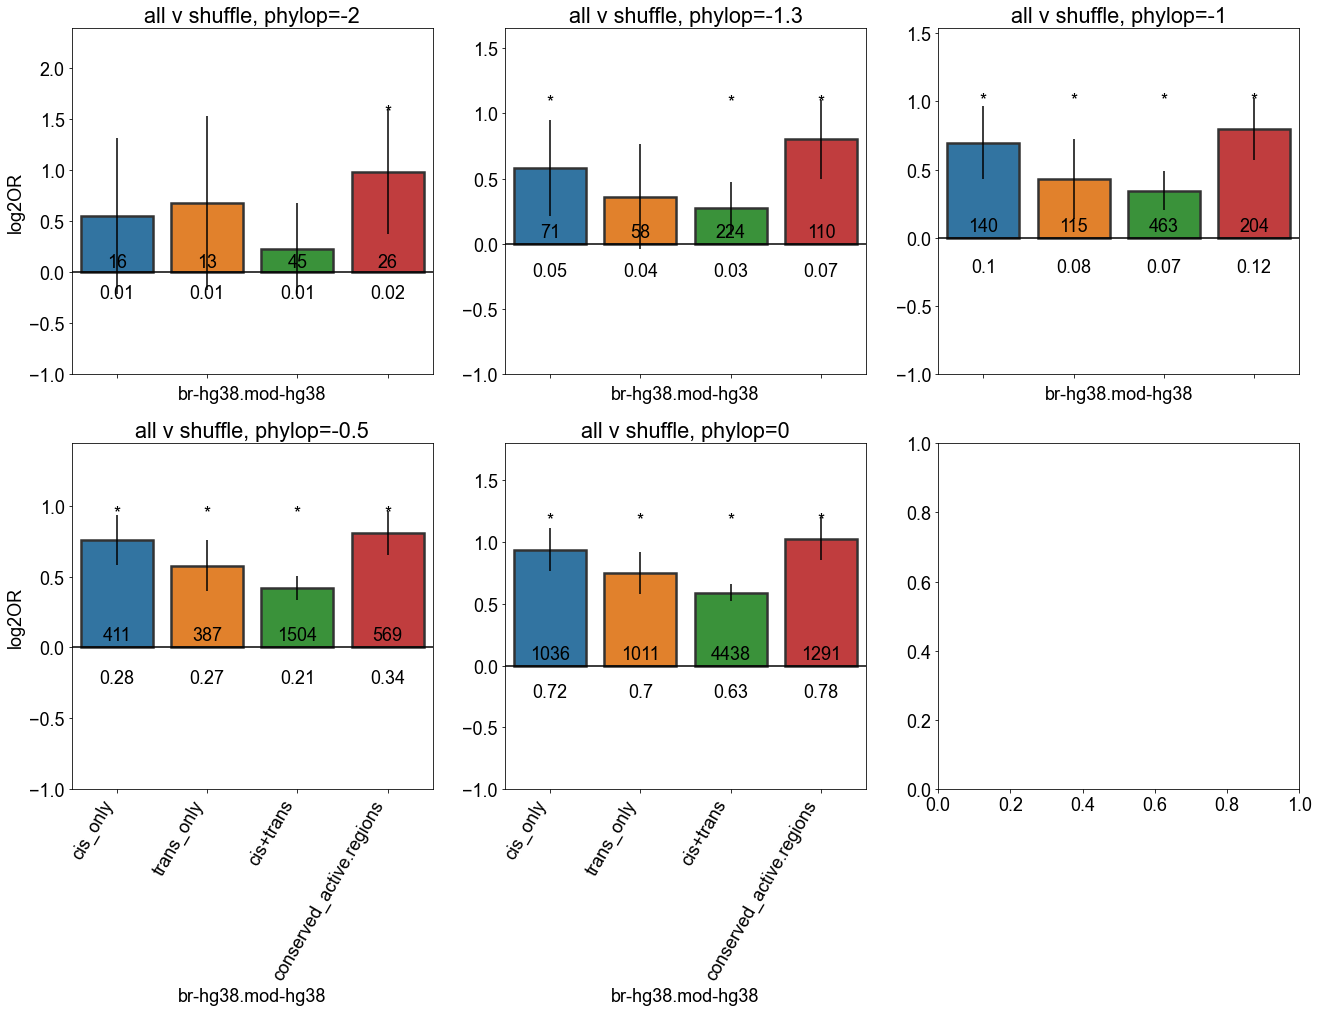

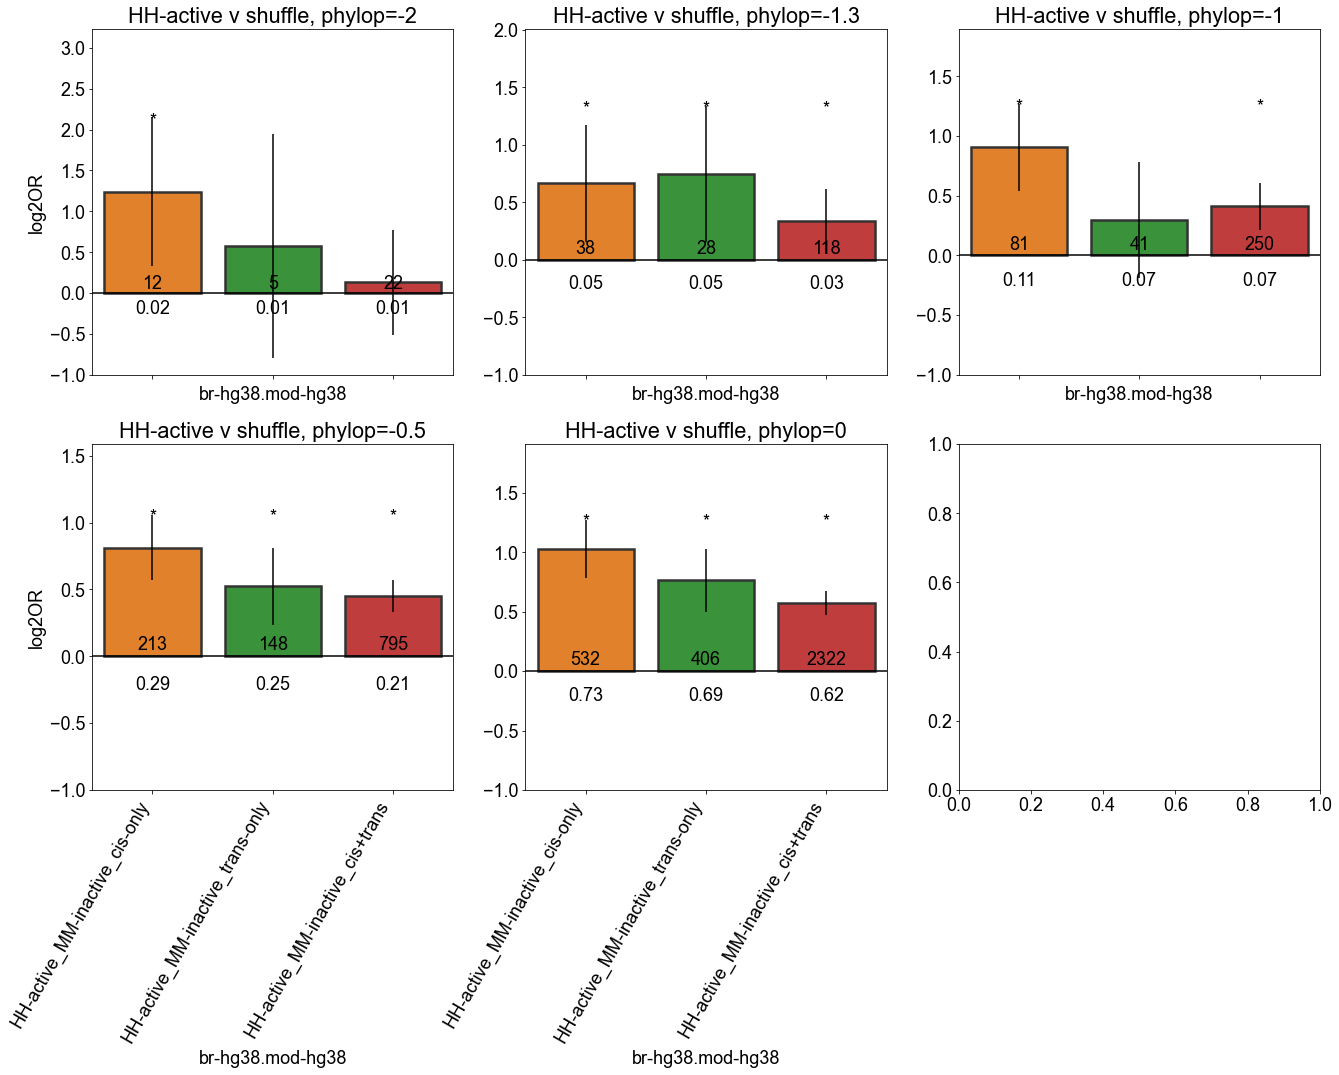

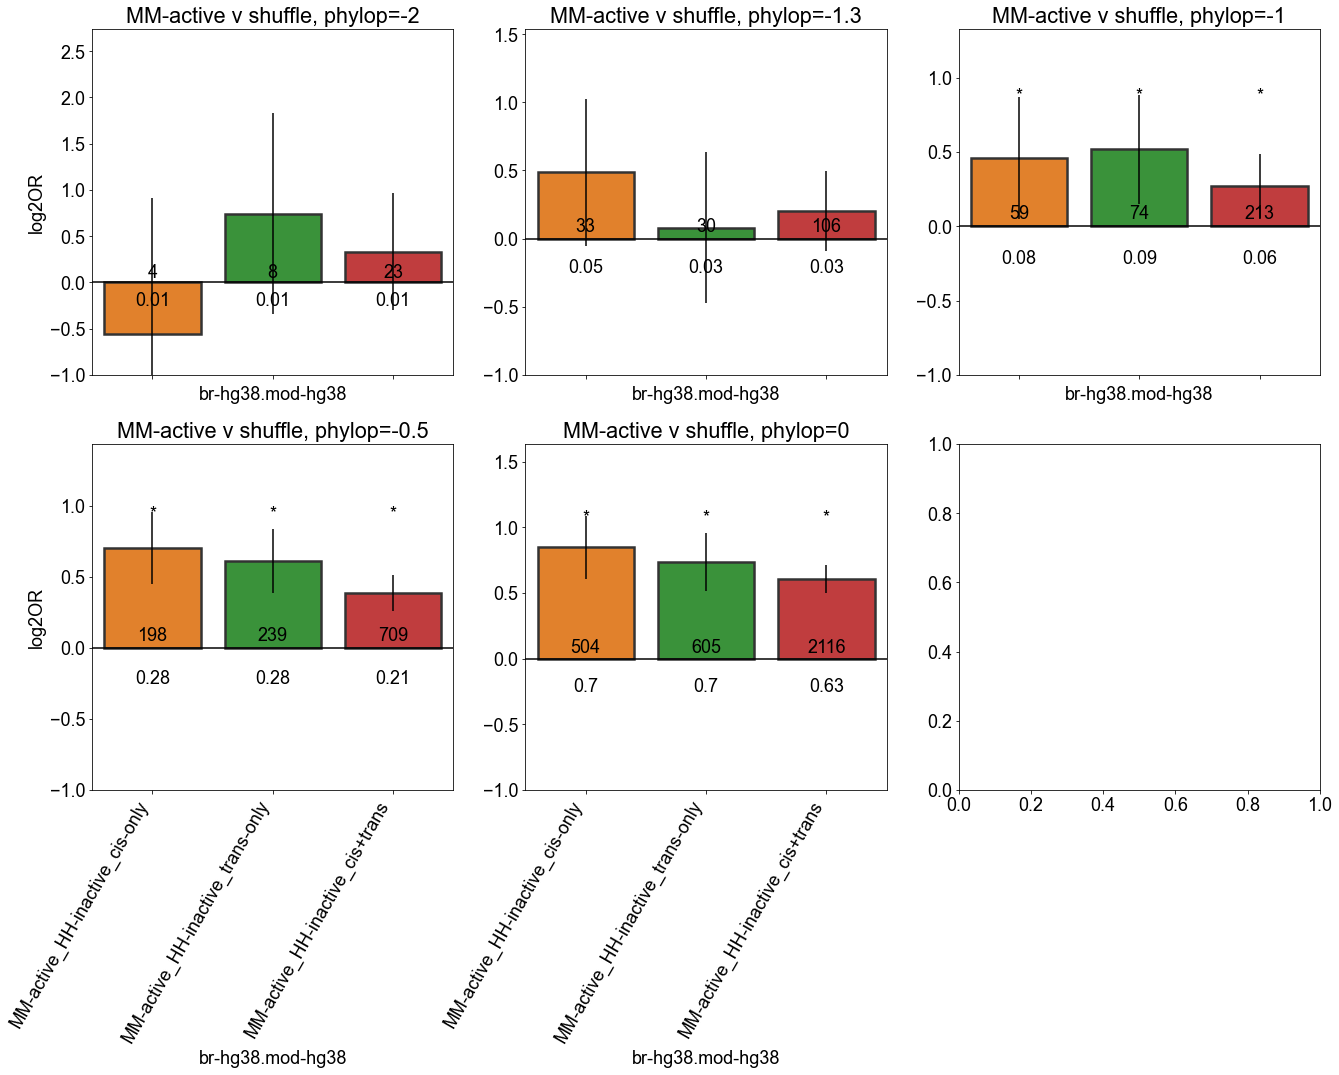

In [34]:
plot_results=results
bkgd = 'shuffle'
plot_or(active_comps, plot_results, bkgd, BRANCH)

## Main text figure

KeyError: 'ci_upper_log2'

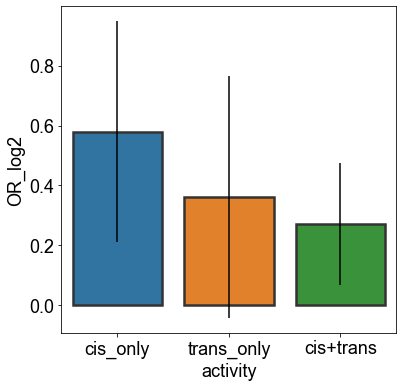

In [35]:
cutoff = -1.3
comps=["cis_only", "trans_only", "cis+trans"]
d = results.loc[(results["activity"].isin(comps))
           &(results["phylop_cutoff"]==cutoff)]

d=reindex_in_comp_order(d, comps)
y="OR_log2"
x="activity"
size="frac"
ci_upper, ci_lower= "ci_upper_log2", "ci_lower_log2"

fig, ax = plt.subplots(figsize =(6,6))
# get difference between y and upper/lower CI for plotting. 
l = np.array(d[y]-d[ci_lower])
u = np.array(d[ci_upper]- d[y])

yerr = [l, u]

sns.barplot(
    x=x, y=y, data=d,
    order = comps,
    
    linewidth=2.5, 
    edgecolor=".2",
    **{"yerr":yerr},
    ax=ax

)


name="hg38-noAPES"

ax.set(xlabel =BRANCH,
       ylabel = "log2OR",
       title=f"{name} v {bkgd}, phylop={cutoff}",
       ylim =(-1, (data[ci_upper].max()+data[ci_upper].max()*0.5))
      )

#if data[ci_lower].min()>-0.2:
 #   ax.set_ylim(-1, (data[ci_upper].max()+data[ci_upper].max()*0.5))

ax.axhline(0, color="k")


ax.set_xticklabels(ax.get_xticklabels(), rotation =60, horizontalalignment="right")



annotate_bar(ax, d["astrisks"], (d[ci_upper].max()-d[ci_upper].max()*0.02))
annotate_bar(ax, d["a"], 0.05)
annotate_bar(ax, d["frac"].round(2),-0.25)
#annotate_bar(ax, data["OR"].round(2), (data[ci_upper].max()-data[ci_upper].max()*0.2))
out = os.path.join(RE, f"{BRANCH}-{name}_v_shuffle_phylop_min.pdf")
plt.savefig(out, bbox_inches="tight")

In [36]:
results.head()

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,...,comparison,bkgd,phylop_cutoff,activity,-log10p,frac,astrisks,reject_null,FDR_P,asterisks
0,26,1634,131,16249,1.973680,3.166671e-03,1.291800,0.611505,3.015491,0.611505,...,conserved_active.regions-region_v_shuf_phylop-2,matched_shufffle,-2.0,conserved_active.regions,2.242255,0.02,*,True,5.724602e-03,*
0,110,1550,641,15739,1.742529,8.099250e-07,1.414026,0.301374,2.147349,0.301374,...,conserved_active.regions-region_v_shuf_phylop-1.3,matched_shufffle,-1.3,conserved_active.regions,5.714805,0.07,*,True,1.928393e-06,*
0,204,1456,1222,15158,1.737959,6.476250e-11,1.484416,0.227498,2.034807,0.227498,...,conserved_active.regions-region_v_shuf_phylop-1,matched_shufffle,-1.0,conserved_active.regions,9.635834,0.12,*,True,2.312947e-10,*
0,569,1091,3767,12613,1.746266,5.044240e-23,1.567986,0.155360,1.944816,0.155360,...,conserved_active.regions-region_v_shuf_phylop-0.5,matched_shufffle,-0.5,conserved_active.regions,21.376385,0.34,*,True,4.203534e-22,*
0,1291,369,10354,6026,2.036202,3.190620e-34,1.805990,0.173090,2.295759,0.173090,...,conserved_active.regions-region_v_shuf_phylop0,matched_shufffle,0.0,conserved_active.regions,32.098185,0.78,*,True,7.976549e-33,*


In [40]:
table = results.pivot(index = "activity", columns = "phylop_cutoff", values = "OR_log2")
ptable = results.pivot(index = "activity", columns = "phylop_cutoff", values = "FDR_P")
atable = results.pivot(index = "activity", columns = "phylop_cutoff", values = "asterisks")
ftable = results.pivot(index = "activity", columns = "phylop_cutoff", values = "frac")

reindex = [
    'conserved_active.regions',
    'cis_only',
    'trans_only',
    'cis+trans',


    'HH-active_MM-inactive_cis-only',
    'HH-active_MM-inactive_trans-only',
    'HH-active_MM-inactive_cis+trans',

    'MM-active_HH-inactive_cis-only',
    'MM-active_HH-inactive_trans-only',
    'MM-active_HH-inactive_cis+trans',
    ]
table=table.loc[reindex]
ptable=ptable.loc[reindex]
atable=atable.loc[reindex]
ftable=ftable.loc[reindex]
#ptable=ptable.round(2)

In [41]:
atable = atable.fillna(" ")
ftable

phylop_cutoff,-2.0,-1.3,-1.0,-0.5,0.0
activity,,,,,
conserved_active.regions,0.02,0.07,0.12,0.34,0.78
cis_only,0.01,0.05,0.10,0.28,0.72
trans_only,0.01,0.04,0.08,0.27,0.70
cis+trans,0.01,0.03,0.07,0.21,0.63
HH-active_MM-inactive_cis-only,0.02,0.05,0.11,0.29,0.73
HH-active_MM-inactive_trans-only,0.01,0.05,0.07,0.25,0.69
HH-active_MM-inactive_cis+trans,0.01,0.03,0.07,0.21,0.62
MM-active_HH-inactive_cis-only,0.01,0.05,0.08,0.28,0.70
MM-active_HH-inactive_trans-only,0.01,0.03,0.09,0.28,0.70


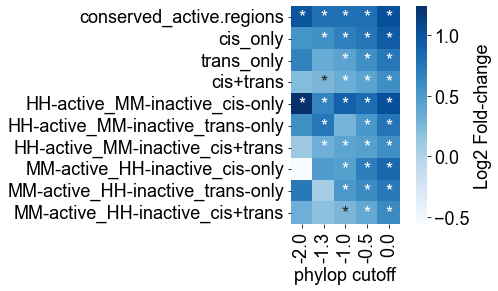

In [39]:
sns.heatmap(table, annot=atable, fmt="", cmap="Blues",square =True,
    cbar_kws={'label': 'Log2 Fold-change'})
plt.xlabel("phylop cutoff")
plt.ylabel("")
out = os.path.join(RE, f"{BRANCH}-shuffle_phylop_min-heatmap.pdf")
plt.savefig(out, bbox_inches="tight")